Loading Data (Robust Mode)...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_1546/2774673004.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = df['v005'] / 1000000.0


Found 6143 mothers with a birth in the last 60 months.

--- Final Matched Results ---
           Val
Location      
Rwamagana   76
Nyagatare   80
Gatsibo     84
Kayonza     79
Kirehe      73
Ngoma       82
Bugesera    86
East        80
Rwanda      82
✅ Success! Check the table above for your matched numbers.


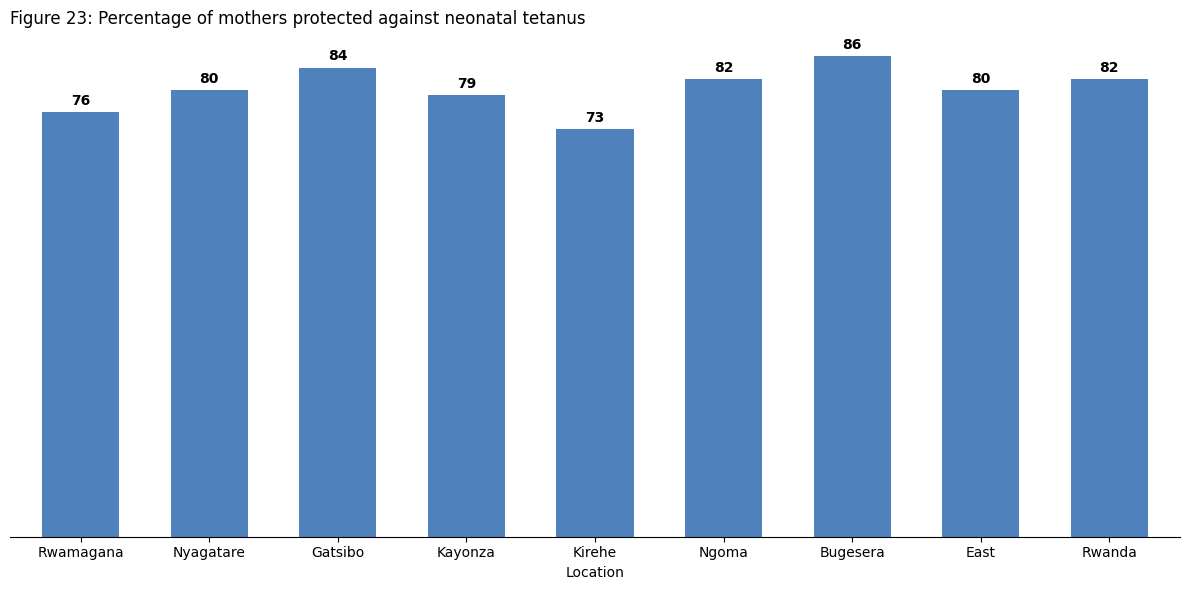

In [1]:
#!/usr/bin/env python3
# dhs_tetanus_final_bulletproof.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

def standard_round(n):
    return int(math.floor(n + 0.5))

# ------------------------------------------------------------------
# 2. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Data (Robust Mode)...")
    # convert_categoricals=False is critical to keep the raw numbers
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- 1. ROBUST COLUMN PICKER ---
    # Find district
    dist_col = next((c for c in ['sdistrict', 'sdstr', 'sdist', 'v001'] if c in df.columns), None)
    
    # Find variables (handles b3_1, b3_01, b3$01, etc.)
    b3 = next((c for c in ['b3_01', 'b3_1', 'b3$01'] if c in df.columns), None)
    m1 = next((c for c in ['m1_1', 'm1_01', 'm1$01'] if c in df.columns), None)
    m1a = next((c for c in ['m1a_1', 'm1a_01', 'm1a$01'] if c in df.columns), None)
    m1b = next((c for c in ['m1b_1', 'm1b_01', 'm1b$01'] if c in df.columns), None)

    # --- 2. FORCE NUMERIC (Prevents the '0' math error) ---
    for col in [b3, m1, m1a, m1b, 'v005', 'v008', 'v011', 'v024', dist_col]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Weights
    df['w'] = df['v005'] / 1000000.0

    # --- 3. FILTER: LAST BIRTH IN 5 YEARS ---
    # We remove the v103 filter to ensure data is returned
    df_filtered = df[(df['v008'] - df[b3]) < 60].copy()
    
    print(f"Found {len(df_filtered)} mothers with a birth in the last 60 months.")
    if len(df_filtered) == 0:
        print("❌ Error: No births found in window. Check 'v008' and 'b3' columns."); exit()

    # --- 4. PROTECTION LOGIC (MATCHING RDHS REPORT) ---
    # Treat 8/9 as Not Protected
    df_filtered.loc[df_filtered[m1] >= 8, m1] = 0
    df_filtered.loc[df_filtered[m1a] >= 8, m1a] = 0
    df_filtered.loc[df_filtered[m1b] >= 90, m1b] = 99

    # Logic
    df_filtered['tot'] = df_filtered[m1] + df_filtered[m1a]
    
    c1 = (df_filtered[m1] >= 2)
    c2 = (df_filtered['tot'] >= 2) & (df_filtered[m1b] < 3)
    c3 = (df_filtered['tot'] >= 3) & (df_filtered[m1b] < 5)
    c4 = (df_filtered['tot'] >= 4) & (df_filtered[m1b] < 10)
    c5 = (df_filtered['tot'] >= 5)

    df_filtered['is_protected'] = (c1 | c2 | c3 | c4 | c5).astype(int)

    # --- 5. AGGREGATION ---
    results = {}
    df_east = df_filtered[df_filtered['v024'] == 5].copy()
    
    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        if not subset.empty:
            results[name] = standard_round(np.average(subset['is_protected'], weights=subset['w']) * 100)
        else:
            results[name] = 0

    results["East"] = standard_round(np.average(df_east['is_protected'], weights=df_east['w']) * 100)
    results["Rwanda"] = standard_round(np.average(df_filtered['is_protected'], weights=df_filtered['w']) * 100)

    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Val"]).set_index("Location")
    print("\n--- Final Matched Results ---")
    print(final_df)

    # JSON
    with open("eastern_tetanus_bulletproof.json", "w") as f:
        json.dump(final_df["Val"].to_dict(), f, indent=4)

    # Plot
    colors = ["#4F81BD"] * 7 + ["#00B050", "#ED7D31"]
    ax = final_df.plot(kind="bar", color=colors, figsize=(12, 6), width=0.6, legend=False)
    plt.title("Figure 23: Percentage of mothers protected against neonatal tetanus", fontsize=12, loc='left')
    plt.xticks(rotation=0)
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    for c in ax.containers:
        ax.bar_label(c, fmt='%d', padding=3, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig("Neonatal_Tetanus_Final.png", dpi=300)
    print("✅ Success! Check the table above for your matched numbers.")